<a href="https://colab.research.google.com/github/Amasha03/Customer_Churn_Prediction/blob/main/notebooks/02_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn Prediction
### CM2604 Machine Learning CourseWork
02-Preprocessing  

Student Name : Amasha Widanagamage  
RGU ID : 2425800  
IIT ID : 20241246

In [17]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import joblib
import math
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [18]:
#Load dataset
from google.colab import drive
df=pd.read_csv('/content/drive/MyDrive/ML/coursework/Telco-Customer-Churn.csv')
print("Original shape:", df.shape)
df.head()


Original shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
#Handle empty values
df=df.replace(' ',np.nan)
df=df.dropna()

#Handle duplicates
df=df.drop_duplicates()

print("Shape after handling value errors:", df.shape)

Shape after handling value errors: (7032, 21)


In [20]:
# Handle Impossible values
df['tenure'] = df['tenure'].clip(lower=0)  # No negative tenure

In [21]:
#Handle TotalCharges
#Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

missing_total=df['TotalCharges'].isnull().sum()
print(f"Number of missing values in TotalCharges: {missing_total}")

Number of missing values in TotalCharges: 0


In [22]:
# Outliers for numerical features
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)

# Fix values
df['tenure'] = df['tenure'].clip(lower=0)  # No negative tenure

print("Outliers handled. Data shape:", df.shape)

Outliers handled. Data shape: (7032, 21)



Outliers in numerical features


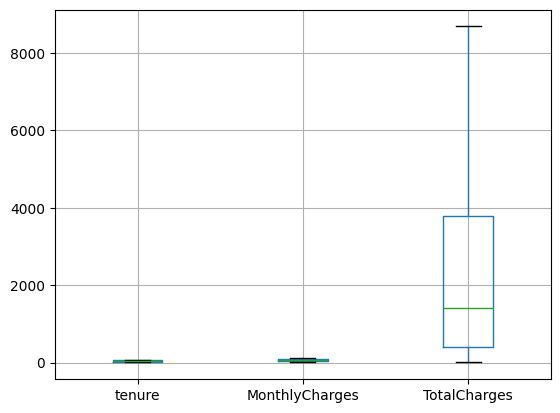


No outliers in any numerical feature.



In [23]:
#Outliers in numerical features
print("\nOutliers in numerical features")
df[['tenure', 'MonthlyCharges', 'TotalCharges']].boxplot()
plt.show()
print("\nNo outliers in any numerical feature.\n")


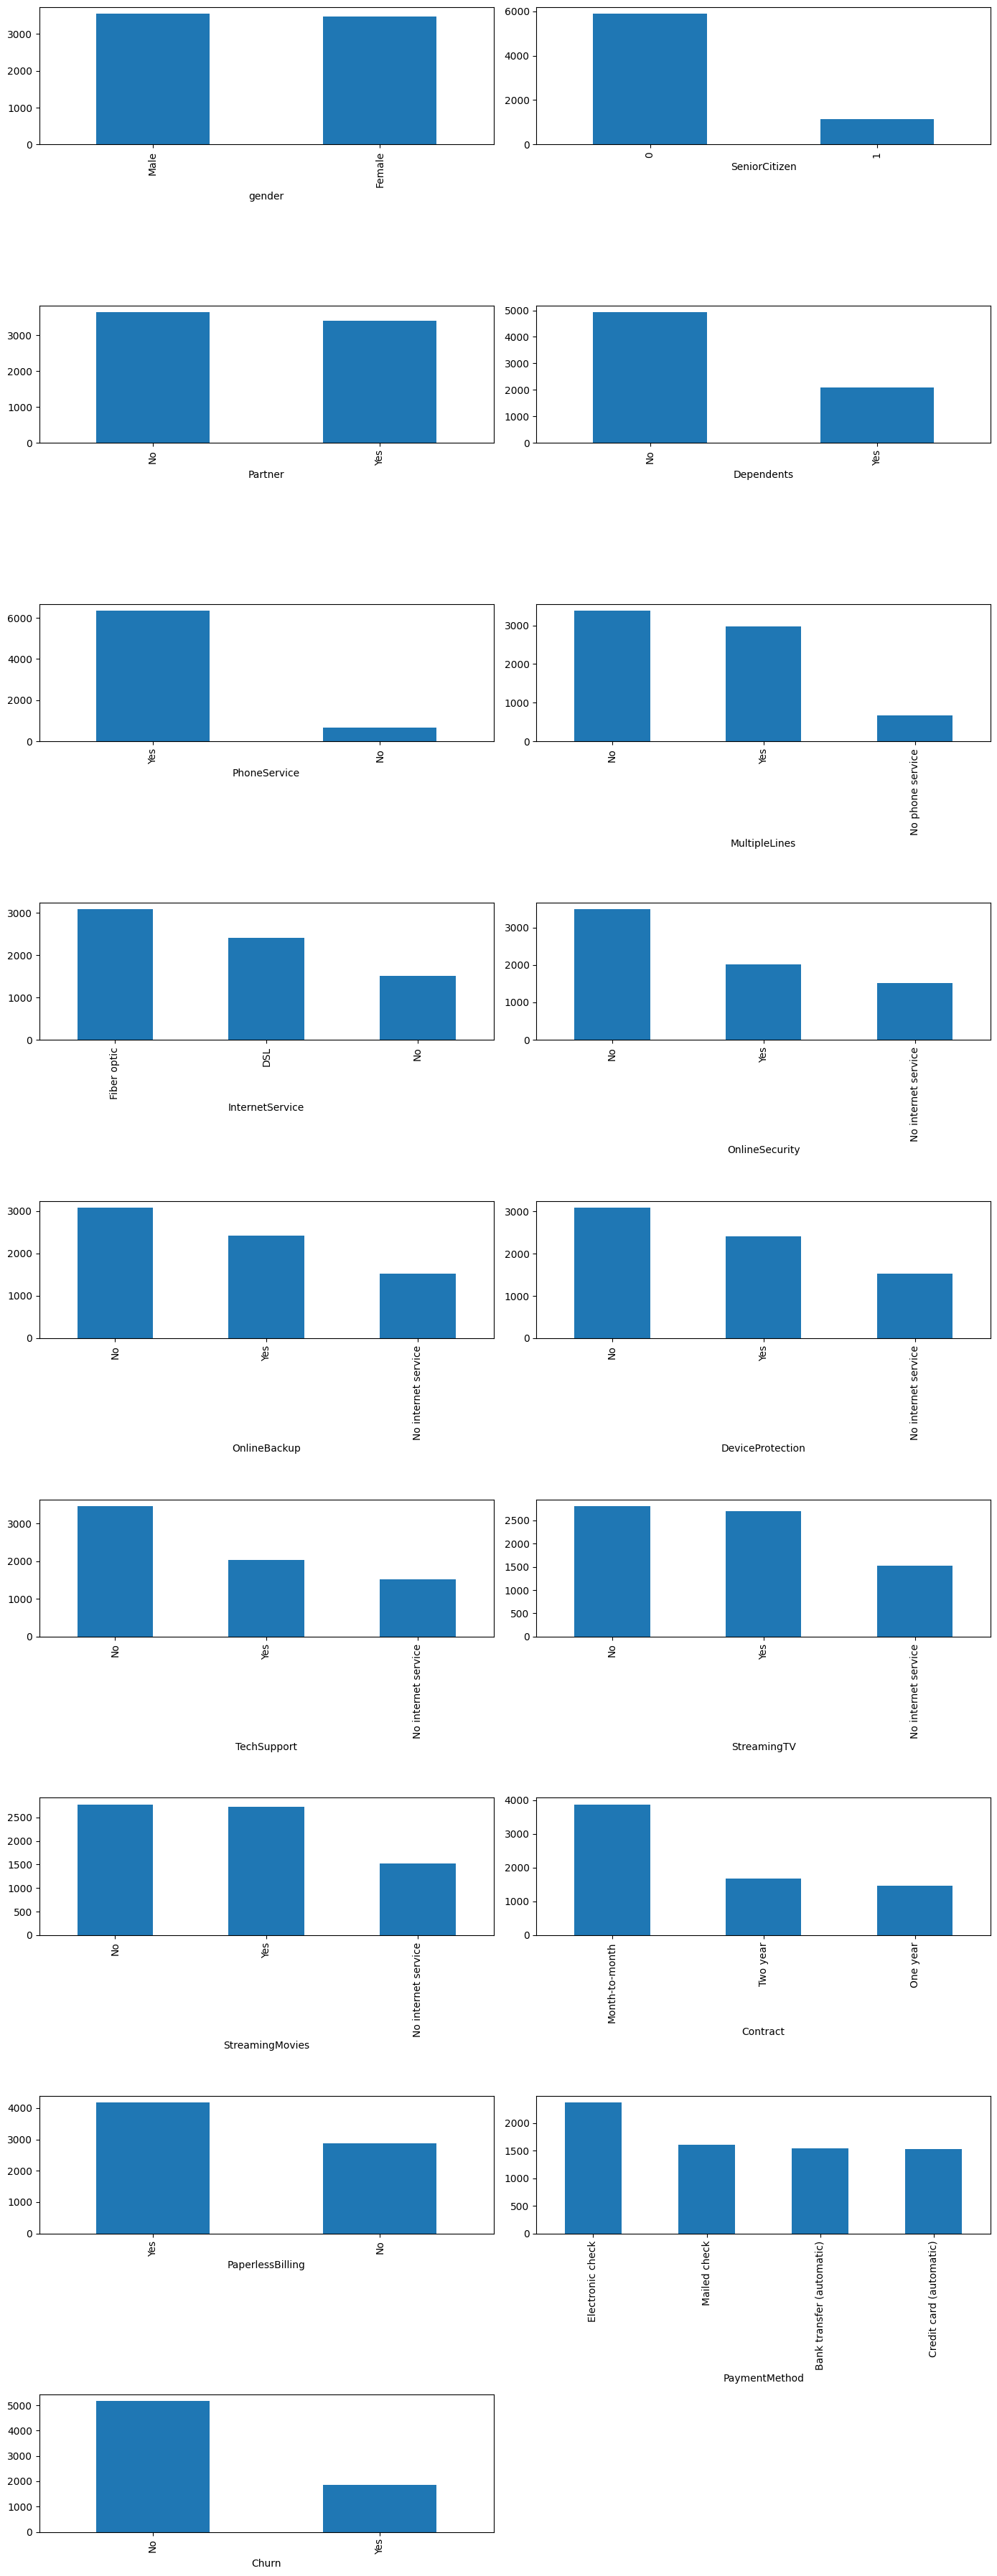

In [24]:
# Bar chart shows frequency of each category
categorical_cols=['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']

cols=2
rows=math.ceil(len(categorical_cols)/cols)

fig,axes=plt.subplots(rows,cols,figsize=(14,rows*4))
axes=axes.flatten()

for i,col in enumerate(categorical_cols):
  df[col].value_counts().plot(kind='bar',ax=axes[i])
  axes[i].tick_params(axis='x',rotation=90)

for j in range(len(categorical_cols),len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [25]:
#Handle Target Variable
#Check what values exist
print("\nChurn values before encoding:")
print(df['Churn'].value_counts(dropna=False))


#Clean and map
df['Churn']=df['Churn'].str.strip().str.capitalize()
df['Churn']=df['Churn'].map({'Yes':1,'No':0})

#Check for unmapped values
print("\nChurn values after mapping:")
print(df['Churn'].value_counts(dropna=False))

#Handle NaN from unmapped values
if df['Churn'].isnull().any():
  df=df.dropna(subset=['Churn'])
  print(f"Dropped rows with NaN in churn.")

df['Churn']=df['Churn'].astype(int)


Churn values before encoding:
Churn
No     5163
Yes    1869
Name: count, dtype: int64

Churn values after mapping:
Churn
0    5163
1    1869
Name: count, dtype: int64


In [26]:
#Encoding binary column
binary_cols=['gender','Partner','Dependents','PhoneService','PaperlessBilling']
for col in binary_cols:
    df[col]=df[col].astype(str).str.strip().str.capitalize()
    df[col]=df[col].map({'Yes':1,'No':0,'Female':1,'Male':0})

    #Fill any NaN with mode
    if df[col].isnull().any():
      df[col].fillna(df[col].mode()[0])
    df[col]=df[col].astype(int)

In [27]:
#Encode categorical columns (One-Hot encoding)
categorical_cols=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']

for col in categorical_cols:
  df[col]=df[col].astype(str).str.strip()

df=pd.get_dummies(df,columns=categorical_cols)



In [28]:
#Scale numerical features
numerical_cols=['tenure','MonthlyCharges','TotalCharges']
scaler=StandardScaler()
df[numerical_cols]=scaler.fit_transform(df[numerical_cols])

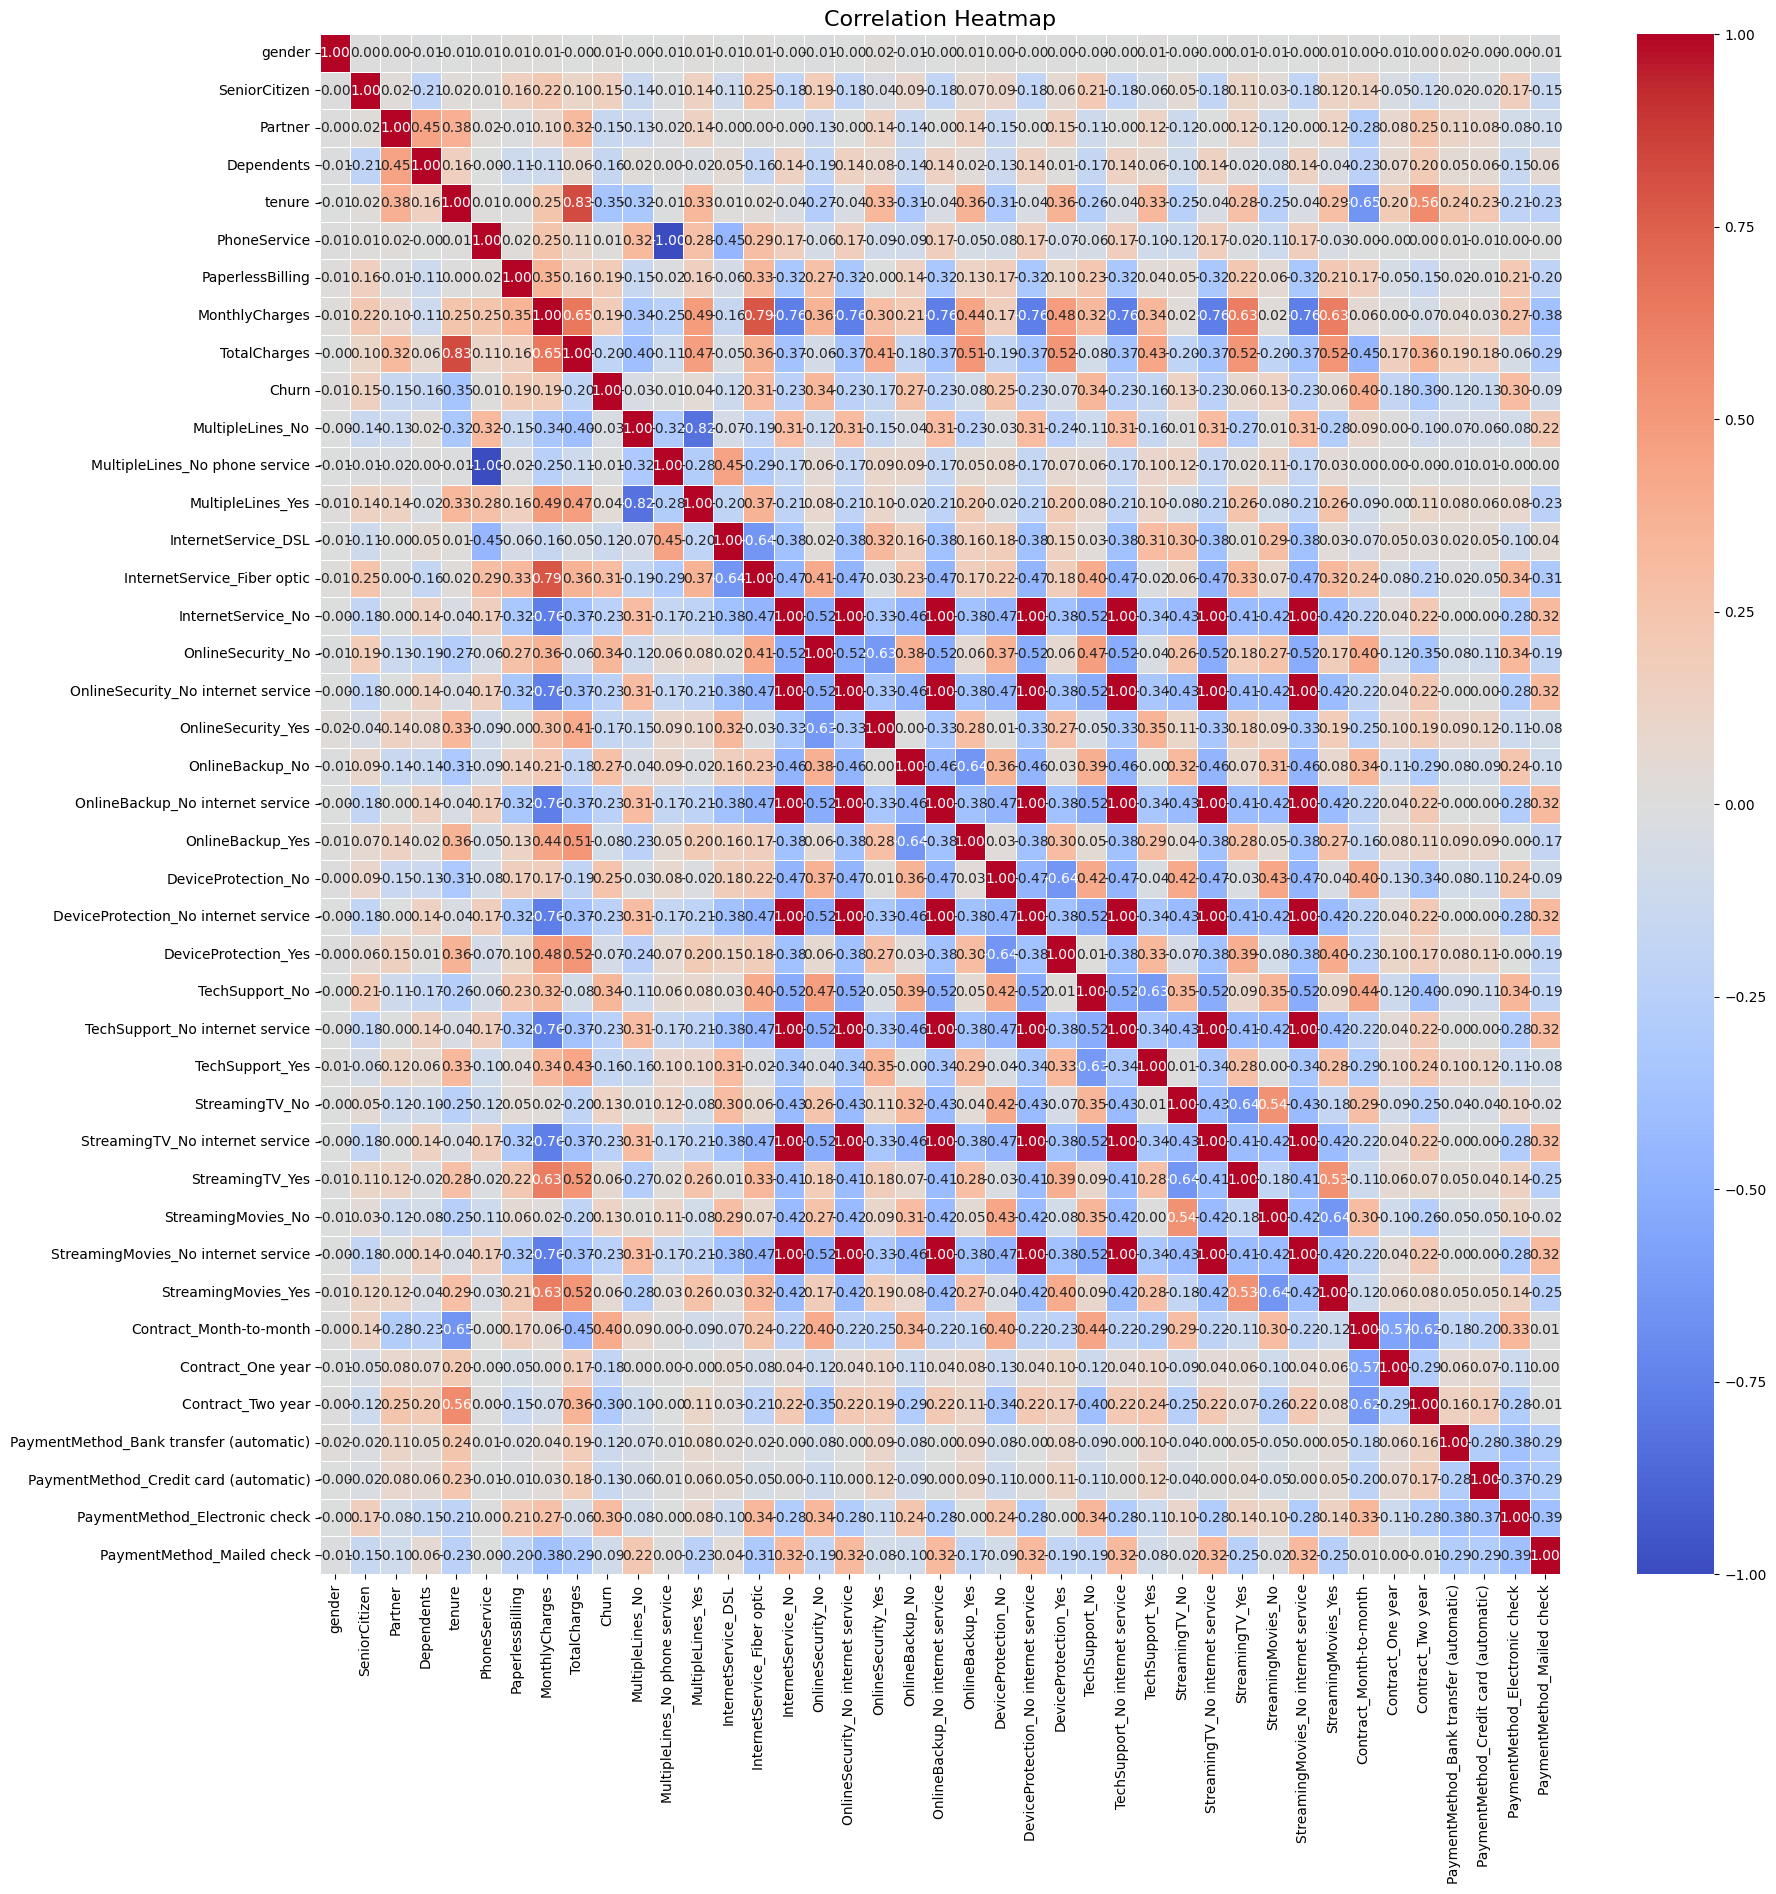

In [29]:
#Compute correlation matrix
corr=df.corr(numeric_only=True)

#plot heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr,annot=True, fmt=".2f", cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [30]:
#Correlation matrix
corr=df.corr(numeric_only=True)

#Select upper triangle of correlation matrix
upper=corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))

#Find features with high correlation
high_corr=[column for column in upper.columns if any (upper[column]>0.85)]

print("Highly correlated features to consider removing: ")
print(high_corr)

df['HasInternet']=(~(df[high_corr]==1).all(axis=1)).astype(int)
df.drop(columns=high_corr,inplace=True)

Highly correlated features to consider removing: 
['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


In [31]:
#Remove unimportant features
#Remove customerId
df.drop(columns=['customerID'])

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,HasInternet
0,1,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,...,True,False,True,False,False,False,False,True,False,1
1,0,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,...,True,False,False,True,False,False,False,False,True,1
2,0,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,...,True,False,True,False,False,False,False,False,True,1
3,0,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,...,True,False,False,True,False,True,False,False,False,1
4,1,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,...,True,False,True,False,False,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,-0.343137,1,1,0.664868,-0.129180,0,...,False,True,False,True,False,False,False,False,True,1
7039,1,0,1,1,1.612573,1,1,1.276493,2.241056,0,...,False,True,False,True,False,False,True,False,False,1
7040,1,0,1,1,-0.872808,0,1,-1.170004,-0.854514,0,...,True,False,True,False,False,False,False,True,False,1
7041,0,1,1,0,-1.158016,1,1,0.319168,-0.872095,1,...,True,False,True,False,False,False,False,False,True,1


In [32]:
df.to_csv('/content/drive/MyDrive/ML/coursework/preprocessed_data.csv',index=False)
print("Dataset saved successfully!")

Dataset saved successfully!
